# PsrSigSim Simulation and PINT Analysis Example

The purpose of this notebook is to exist as an example for how to run the pulsar signal simulator, get TOAs, and then process the simulated data. All files that are pointed to should exist in the same directory except for the fitsfile we write the simulated data into (and as such this notebook will not run all the way through) until/unless I get explicit permission to put the data file up. Otherwise any existing template fits file should work as long as appropriate values are used when making the initial simulation.

This notebook will work using only the bjs-subint branch of the pulsar signal simulator which can be found at https://github.com/bshapiroalbert/PsrSigSim/tree/bjs-subint. It will currently not work with any other version or branch of the simulator (this will be updated in the near future). 

In addition, you will need to have the PINT pulsar timing python package (https://github.com/nanograv/PINT/tree/master/pint), the pypulse python package (https://github.com/mtlam/PyPulse/tree/master/pypulse), and PSRCHIVE software installed to get the TOAs automatically. 

## Import packages and define simulation functions

In [1]:
# Import desired packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import psrsigsim as PSS
import numpy as np
import scipy.interpolate as interp
import scipy
import scipy.stats
from scipy import stats
import scipy.signal as spsig
import os
import subprocess
from datetime import datetime
#import __future__
import h5py
import glob
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation
import pdat
import types
# pypulse
import pypulse.archive as arch
from pypulse.tim import Tim
import pypulse as pp
# pint
import pint
import pint.toa as toa
import pint.models as models
import pint.residuals as r
import pint.fitter as fit
import astropy.units as u
import astropy.table as table
from astropy.io import fits
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit

%matplotlib inline

/home/bjs0024/.local/lib/python2.7/site-packages/subprocess32.py:146: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
# Define some useful functions:

# This removes the hdf5 file if it already exists to create a new signal
def checksimsig():
    if os.path.exists("signal.hdf5"):
        subprocess.call("rm signal.hdf5",shell=True)
    if os.path.exists("full_signal.hdf5"):
        subprocess.call("rm full_signal.hdf5",shell=True)
        
def call(x):
    subprocess.call(x,shell=True)
    
def callvar(x):
    variable = subprocess.check_output(x, shell=True)
    return variable


In [3]:
# We define a function to create a variety of DM variations (at least simply)
def DMvars(dm, epochs, epoch_length = 30.0, variation = 'both', slope = 1.0, \
            amplitude = 1.0, period = 365.0):
    """
    This version of the function will take in a slope (10^-3 pc cm^-3 yr^-1), 
    amplitude (10^-4 pc cm^-3), and period (days) as reported as in Jones et al. 2017
    to determine what the DM variations should look like.
    
    The inputs here are the DM of the pulsar and the number of epochs, or simulated files
    or values of DM we want to input. For now these are all done with linear spacings using
    numpy.linspace. Future versions could add different sampling. The other inputs are:
    epoch_length - time between epochs, e.g. in days, e.g. the default is one month,
                   meaning that there will be one month between epochs.
    variation - can be 'none', linear', 'periodic' (sinusoidal), or 'both'. Gives the trend 
                of DM variations to simulate. If none will return a list with epoch number
                of the input DM.
                NOTE: for sinusiodal variations, we will have one cycle for every 4 epochs
                      as a default for now.
    slope - slope of the linear trend of DM variations over one year (10^-3 pc cm^-3)
    amplitude - The amplitude of the sinusoidal trend (10^-4 pc cm^-3)
    period - period of the sinusoidal trend (days)
    """
    # Find the total time the DM is varying over in days:
    set_length = epochs*epoch_length # total days the data set spans
    
    if variation == 'linear':
        # find the overall scale of the variations depending on the slope
        set_slope = slope*(set_length/365.0) # overall linear change over the data set
        DM_values = np.linspace(dm-(set_slope*10**-3/2.0), dm+(set_slope*10**-3/2.0), epochs)
    elif variation == 'periodic':
        cycles = set_length/period # number of cycles
        DM_values = np.sin(np.linspace(0, cycles*2*np.pi, epochs))*amplitude*10**-4+dm
    elif variation == 'both':
        # find the overall scale of the variations depending on the slope
        set_slope = slope*(set_length/365.0) # overall linear change over the data set
        DM_linear = np.linspace(dm-(set_slope*10**-3/2.0), dm+(set_slope*10**-3/2.0), epochs)
        # Now get the periodic component
        cycles = set_length/period # number of cycles
        DM_periodic = np.sin(np.linspace(0, cycles*2*np.pi, epochs))*amplitude*10**-4
        # Get the total DM variation
        DM_values = DM_linear+DM_periodic
    elif variation == 'none':
        DM_values = np.repeat(dm, epochs)
    else:
        print("ERROR: Incompatible DM variation specified. Returning input DM value.")
        DM_values = np.repeat(dm, epochs)
    return DM_values


In [4]:
# We define a function to adjust the signal to noise and resave the data
def scalenoise(sim, psr_dict, Lbandscale = False, EqScale = False):
    """
    Added EqScale variable. If this is true, we will scale the noise in the
    residuals equally for all injected files regardless of frequency.
    """
    # get the number of subintegrations
    nsubint = int(sim.pulsar.ObsTime/1000./sim.pulsar.subintlen)

    # Define the psrfits file we would like to use as a template
    if 'tempfits' in sim.sim_dict.keys():
        fitstemplate =sim.sim_dict['tempfits']
    else:
        if psr_dict['telescope'] == 'Arecibo' and psr_dict['freq_band'] == 1400.0:
            if psr_dict['ObsTime']/1000.0 > 1000.0:
                # For this one, total integrated SN should be around 1000-1100ish
                fitstemplate = "/hyrule/data/users/bjs0024/SigSim_Project1/template_files/puppi_57627_B1855+09_1077_Full_noDMX.fits"
            else:
                fitstemplate = "/hyrule/data/users/bjs0024/SigSim_Project1/template_files/puppi_57627_B1855+09_1077_0001.fits"
        elif psr_dict['telescope'] == 'Arecibo' and psr_dict['freq_band'] == 430.0:
            fitstemplate = "/hyrule/data/users/bjs0024/SigSim_Project1/template_files/puppi_57627_B1855+09_1075_0001.fits"
        elif psr_dict['telescope'] == 'GBT':
            fitstemplate = "/hyrule/data/users/bjs0024/SigSim_Project1/template_files/guppi_57162_J1918-0642_0026_0001.fits"
        else:
            print("Unrecognized telescope, defaulting template file")
            fitstemplate = "/hyrule/data/users/bjs0024/SigSim_Project1/template_files/puppi_57627_B1855+09_1077_0001.fits"

    # Get the signal
    pulse_signal = sim.signal.signal[:,:]
    # Get the telescope noise
    telescope_noise = sim.telescope_noise[:,:]

    # We define the signal we would actually like to save
    if EqScale == False:
        if psr_dict['freq_band'] == 1400.0:
            if psr_dict['ObsTime']/1000.0 > 1000.0:
                likereal_signal = pulse_signal+(telescope_noise)*20/np.sqrt(2.0) # need to change this
            else:
                if Lbandscale:
                    # To scale a single 86 second file for SNR of a 20 minute observation
                    likereal_signal = pulse_signal+(telescope_noise)*5/np.sqrt(2.0)
                else:
                    likereal_signal = pulse_signal+(telescope_noise)*20/np.sqrt(2.0)
        elif psr_dict['freq_band'] == 430.0:
            likereal_signal = pulse_signal+(telescope_noise)*325/np.sqrt(2.0)
        else:
            print("Unrecognized frequency band, defaulting to 1400 MHz corrections")
            likereal_signal = pulse_signal+(telescope_noise)*20/np.sqrt(2.0)
    else:
        # attempt to scale the SN equally at both frequencies
        if psr_dict['freq_band'] == 1400.0:
            likereal_signal = pulse_signal+(telescope_noise)*23/np.sqrt(2.0)
        elif psr_dict['freq_band'] == 430.0:
            likereal_signal = pulse_signal+(telescope_noise)*600/np.sqrt(2.0)
        else:
            print("Unrecognized frequency band, defaulting to 1400 MHz corrections")
            likereal_signal = pulse_signal+(telescope_noise)*23/np.sqrt(2.0)

    # Get the array for the setMJD parameter
    # setMJD = [obslen, period, initMJD, initSMJD, initSOFFS, initOFFSUB, increment_length]
    psrfits1=pdat.psrfits('dataslave.fits',from_template=psr_dict['tempfits'],obs_mode='PSR')
    for ky in psrfits1.draft_hdr_keys[1:]:
        psrfits1.copy_template_BinTable(ky)
    subint = psrfits1.draft_hdrs['SUBINT']
    for ky in subint.keys():
        if subint[ky] == "OFFS_SUB":
            idx = int(ky.split("E")[-1])-1
    OFFS_SUB = psrfits1.HDU_drafts['SUBINT'][0][idx]
    psrfits1.close()
    os.remove('dataslave.fits')

    setMJD = [sim.signal.ObsTime/1000.0, 1.0/psr_dict['F0'], psr_dict['Start_MJD'][0],              psr_dict['Start_MJD'][1], psr_dict['Start_MJD'][2], OFFS_SUB, psr_dict['increment_length']]
    # now we need to save this as a fits file
    PSS.PSS_utils.save_psrfits(likereal_signal, template=fitstemplate, nbin = 2048, \
                               nsubint = nsubint, \
                               npols = 1, nf = psr_dict['Nf'], \
                               tsubint = sim.pulsar.subintlen, check = True,\
                               DM = sim.ISM.DM, freqbins = sim.signal.freq_Array, \
                               setMJD = setMJD)



In [5]:
"""
MAJOR NOTE/ISSUE:
While we can phase connect any number of files with any number of subints initially, if we
fold them with PSRCHIVE, which ideally we do want to do, I don't know what PSRCHIVE is doing
or how it re-timestamps things afterwards, which means despite my best efforts, PSRCHIVE
unphase connects things. So to fix this for now, we need to write a function to re-phase 
connect the files. Oh well.

We only need the fitsfile and the initial simulation dictionary. This only works with that 
dictionary for right now.
"""
def rephaseconnect(fitsfile, sim_dict):
    # We open up the fits file and reformat the appropriate dates
    new_psrfits = "placeholdername.fits"
    psrfits1=pdat.psrfits(new_psrfits,from_template=fitsfile,obs_mode='PSR')
    for ky in psrfits1.draft_hdr_keys[1:]:
        psrfits1.copy_template_BinTable(ky)
    
    # Get the number of subintegrations from the fitsfile
    nsubint = psrfits1.draft_hdrs['SUBINT']['NAXIS2']
    
    # Get the values needed from the simulation dictionary
    obslen = sim_dict['ObsTime']/1000.0 # seconds
    period = 1.0/sim_dict['F0'] # seconds
    increment_length = sim_dict['increment_length'] # days
    initMJD = sim_dict['Start_MJD'][0] # MJD
    initSMJD = sim_dict['Start_MJD'][1] # seconds
    initSOFFS = sim_dict['Start_MJD'][2] # seconds
    if nsubint == 1:
        initOFFSUB = np.float64(42.32063) # seconds
    else:
        initOFFSUB = sim_dict['Start_MJD'][3] # seconds
        
    # We will start basically by calling the next_MJD function to get the new values for things
    SMJD, SOFFS, MJD, saveMJD, newOFFSUBs = PSS.PSS_utils.nextMJD(obslen, period,                                             initMJD = initMJD, initSMJD = initSMJD,                                             initSOFFS = initSOFFS, initOFFSUB = initOFFSUB,                                             nsubint = nsubint, increment_length = increment_length)
    
    # now we want to replace the appropriate values
    psrfits1.set_draft_header('PRIMARY',{'STT_IMJD':int(saveMJD),'STT_SMJD':int(SMJD),                                        'STT_OFFS':float(SOFFS)})
    
    try:
        # If we have a normal fits file this will work fine
        psrfits1.HDU_drafts['POLYCO'][0][8] = MJD
    except:
        """If we have the file put together by psradd, it doesn't have a 
        'POLYCO' header, instead it has 'T2PREDICT' which has a time range
        parameter to be replaced instead."""
        #print("No POLYCO header, replacing T2PREDICT TIME_RANGE instead")
        trange_start = np.float64(MJD - (obslen/86400.0))
        trange_stop = np.float64(MJD + 2*(obslen/86400.0))
        predict_replace = "TIME_RANGE %s %s" % (trange_start, trange_stop)
        #print(predict_replace)
        psrfits1.HDU_drafts['T2PREDICT'][4][0] = predict_replace
    #psrfits1.HDU_drafts['POLYCO'][0][8] = MJD
    for i in range(nsubint):
            psrfits1.HDU_drafts['SUBINT'][i]['OFFS_SUB'] = newOFFSUBs[i]
            
        
    psrfits1.write_psrfits(hdr_from_draft=True)
    psrfits1.close()
    # Now we want to give it it's old name back
    call("mv %s %s" % (new_psrfits, fitsfile))


In [6]:
# We define a function to remove these parameters
def delpsrparams(fitsfile):
    # We open up the fits file
    new_psrfits = "placeholdername.fits"
    psrfits1=pdat.psrfits(new_psrfits,from_template=fitsfile,obs_mode='PSR')
    for ky in psrfits1.draft_hdr_keys[1:]:
        psrfits1.copy_template_BinTable(ky)
    # Now we want to go through and edit out the things we didn't simulate (e.g. F1, binary)
    badparams = ["F1", "PMDEC", "PMRA", "BINARY", "A1", "E", "T0", "PB", "OM", "SINI", "M2"]
    for param in psrfits1.HDU_drafts['PSRPARAM']:
        for bp in badparams:
            if bp in param[0]:
                idx = np.where(param == psrfits1.HDU_drafts['PSRPARAM'])[0]
                psrfits1.HDU_drafts['PSRPARAM'] = np.delete(psrfits1.HDU_drafts['PSRPARAM'], idx)
    # Now we want to resave the file
    psrfits1.write_psrfits(hdr_from_draft=True)
    psrfits1.close()
    # Now we want to give it it's old name back
    call("mv %s %s" % (new_psrfits, fitsfile))


In [7]:
# and we define a function to get TOAs from the simulated data
def getSimTOAs(fitsfiles, tempfile, scrunch = False, nchan = 64, nsubint = 1, npol = 1,\
                  sim_dict = None, inc_lens = None):
    """
    This function will take a single or list of fitsfiles of simulated data and run 
    PSRCHIVE calls to get TOAs from the simulated fits files, and scrunch the data to a 
    number of frequency channels and subintegrations is desired. It then also barycenters
    all of the TOAs (e.g. replaces the observatory code with '@') and also saves all the
    TOAs as one big file with "_ALL.tim" at the end. The inputs are as follows:
    fitsfiles - a single or list of fits file names (and paths to) to get TOAs from
    tempfile - Profile template fits file to make TOAs with (since we are only using
               PSRCHIVE for now)
    scrunch - if False, don't manipulate the data, just get the TOAs. If True, we will
              first scrunch the fits files to the number of frequency channels (nchan),
              subintegrations (nsubint), and polarizations (npol), given as input.
              The new fits files will be stored in the same place as the originals with
              the extension: .f'nchan't'nsubint'p'npol'
    """
    # If a single fitsfile string, put it into a list
    if isinstance(fitsfiles ,types.StringTypes):
        fitsfiles = [fitsfiles]
    # Now check if we want to scrunch the files and if so do it
    if scrunch:
        # figure out the factor we need to scrunch; start with frequency
        if nchan == 1:
            freq_flag = " -F "
        else:
            freq_flag = " --setnchn %s " % (nchan)
        # then polarization
        if npol == 1:
            pol_flag = " -p "
        else:
            pol_flag = "" # don't thing we can scrunch to 2 from 4, not sure though
        # and subintegrations
        if nsubint == 1:
            sub_flag = " -T "
        else:
            sub_flag = " --setnsub %s " % (nsubint)
        # Now put it all together
        scrunchfits = []
        ext = "f%st%sp%s" % (nchan, nsubint, npol)
        for ff in fitsfiles:
            scrunchcall = "pam -e " + ext + freq_flag + pol_flag + sub_flag + ff
            call(scrunchcall)
            scrunchfits.append(ff.split(".")[0]+"."+ext)
        # Then reassign the fits files if we needed to scrunch the,
        fitsfiles = scrunchfits
        # Now if there's also a dictionary of simulated parameters, we need to adjust things
        if sim_dict != None:
            k = 0
            while k < len(fitsfiles):
                sim_dict['increment_length'] = inc_lens[k]
                rephaseconnect(fitsfiles[k], sim_dict)
                k += 1
    # Now once we've scrunched we get the TOAs
    TOAcall = "pat -A FDM -e mcmc=0 -C chan -C subint -C snr -C wt  -C rcvr:name -f tempo2 IPTA -s %s "\
                % (tempfile)
    timfiles = []
    for ff in fitsfiles:
        print(ff)
        call(TOAcall+"%s > %s.tim" % (ff, ff))
        timfiles.append(ff+".tim")
    # now we need to tell the tim files that the TOAs are barycentred
    alltimlines = ["FORMAT 1 \n"]
    for t_f in timfiles:
        # Go through the tim file line by line
        lines = []
        with open(t_f, 'r') as tf:
            for line in tf:
                # Get other necessary lines
                if "FORMAT" in line:
                    lines.append(line)
                # replace the observatory codes and receiver name and add the lines
                elif 'ao' in line:
                    newline = line.replace('ao', '@')
                    newline = newline.replace("-rcvr:name lbw", "-fe L-wide")
                    newline = newline.replace("-rcvr:name 430", "-fe 430")
                    lines.append(newline)
                    alltimlines.append(newline)
                elif 'gbt' in line:
                    newline = line.replace('gbt', '@')
                    newline = newline.replace("-rcvr:name lbw", "-fe L-wide")
                    newline = newline.replace("-rcvr:name 430", "-fe 430")
                    lines.append(newline)
                    alltimlines.append(newline)
                else:
                    print("Weird line: %s" % (line))
            tf.close()
        # now we write out the new file
        with open(t_f, 'w') as nt:
            nt.writelines(lines)
            nt.close()
    # Now write one big file with all the TOAs in it
    fulltim = timfiles[0].split('.ti')[0]+'_ALL.tim'
    print("All simulated TOAs can be found in:", fulltim)
    with open(fulltim, 'w') as ft:
        ft.writelines(alltimlines)
        ft.close()
    
    # and return the name of this last fits file
    return fulltim

In [8]:
"""
We will plot the FD parameter polynomial curves now. Inputs will be:
FDs - list or array of FD parameters
freqs - array of frequencies in MHz to evaluate at
"""
def FDcurve(FDs, freqs, error=False, FDerrs=None):
    delta_t_FD = 0
    i = 0
    while i < len(FDs):
        delay = FDs[i]*np.log10(freqs/1000.0)**(i+1)
        delta_t_FD += delay
        i += 1
    # convert to microseconds
    delta_t_FD *= 10**6
    # figure out what values we should return and if the error should be calculated
    if error==False:
        return delta_t_FD
    elif error==True and type(FDerrs)==type(None):
        print("No FD errors provided, returning just delta_t...")
        return delta_t_FD
    else:
        # calculate the error and return that as well
        i = 0
        delta_t_var = 0
        while i < len(FDs):
            # calculate the error on each point
            FD_err = FDerrs[i]**2 * (np.log10(freqs/1000.0)**(i+1))**2
            # add in quadrature
            delta_t_var += FD_err
            i += 1
        # take square root for 1sigma value
        delta_t_sigma = np.sqrt(delta_t_var)*10**6 # get in microseconds
        return delta_t_FD, delta_t_sigma

## Simulate the Data

Our example simulation will create a single L-band observation of the pulsar B1855+09. Most parameters used will come from the NANOGrav 11-yr par file. Other parameters wil need to be defined based on the parameters of the template fits file being used.

In [38]:
psr = "B1855+09"
# Check the par file for F0 and dm
if os.path.exists("%s_NANOGrav_11yv0.gls.par" % (psr)):
    parfile = "%s_NANOGrav_11yv0.gls.par" % (psr)
    F0 = float(callvar("cat %s | grep 'F0'" % (parfile)).split()[1])
    dm = float(callvar("cat %s | grep 'DM '" % (parfile)).split()[1])
else:
    F0 = 100.0 # Hz
    dm = 10.0

# Check the values:
print(dm, F0)

(13.299393, 186.49408124993144)


In [39]:
"""
This cell opens up the template file (subject to change) to get the OFFS_SUB parameter
from the fits file metadata to help phase connect the simulated pulses.
"""

ref_fits = "puppi_57627_B1855+09_1077_0001.fits"

psrfits1=pdat.psrfits('dataslave.fits',from_template=ref_fits,obs_mode='PSR')
for ky in psrfits1.draft_hdr_keys[1:]:
    psrfits1.copy_template_BinTable(ky)
subint = psrfits1.draft_hdrs['SUBINT']
for ky in subint.keys():
    if subint[ky] == "OFFS_SUB":
        idx3 = int(ky.split("E")[-1])-1
init_OFFS_SUB = psrfits1.HDU_drafts['SUBINT'][0][idx3]
psrfits1.close()
os.remove('dataslave.fits')
print(init_OFFS_SUB)

Making new PSR mode PSRFITS file using template from path:
    'puppi_57627_B1855+09_1077_0001.fits'. 
Writing to path: 
    'dataslave.fits'
The Binary Table HDU headers will be written as they are added
     to the PSRFITS file.

0.49208970561305937


In [40]:
# Define the dictionary of pulsar parameters for Lband_MHz for a single file
B1855_Lband_dict = {}
B1855_Lband_dict['f0'] = 1380 # center frequency of the fits file
B1855_Lband_dict['bw'] = 800 # bandwith of template fits file
B1855_Lband_dict['Nf'] = 512 # number of frequency channels in fits file
B1855_Lband_dict['data_type']='float32'
B1855_Lband_dict['SignalType'] = "intensity" 
B1855_Lband_dict['freq_band'] = 1400
B1855_Lband_dict['ObsTime'] = 64*(84.64126/64.0)*1000 # length of observation (in ms)
B1855_Lband_dict['to_DM_broaden'] = False
B1855_Lband_dict['radiometer_noise'] =  True
B1855_Lband_dict['telescope'] = 'Arecibo'
B1855_Lband_dict['subintlen'] = 84.64126/64.0 # seconds length of subintegration
B1855_Lband_dict['pulsar'] = psr
B1855_Lband_dict['flux'] = 5.0 # in mJy, from PSRCAT
B1855_Lband_dict['F0'] = F0
B1855_Lband_dict['dm'] = dm
B1855_Lband_dict['f_samp'] = F0*2048*10**-6 # sampling rate, defined for 2048 bins per pulse
B1855_Lband_dict['tempfits'] = "puppi_57627_B1855+09_1077_0001.fits" # this is subject to change
B1855_Lband_dict['phaseconnect'] = True
B1855_Lband_dict['increment_length'] = 0.0 # days
B1855_Lband_dict['Start_MJD'] = [56000.0, 0.0, 0.5, init_OFFS_SUB] 
#B1855_Lband_dict['FD'] = [1.287e-4, -1.475e-4, 8.159e-5] # optional FD parameters to inject

Loading: B1855+09.L-wide.PUPPI.11y.x.sum.sm
Load time: 0.31 s


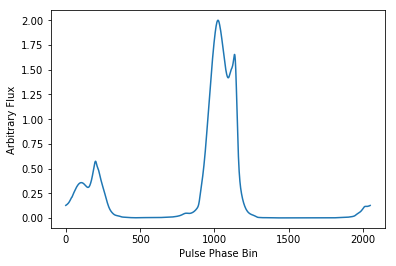

In [41]:
# Now we load in and define the pulse profile template as the NANOGrav 11-yr template
nanotemp_Lband = "B1855+09.L-wide.PUPPI.11y.x.sum.sm"
temp_Lband = arch.Archive(nanotemp_Lband, lowmem = True)
temp_Lband_ar = temp_Lband.getData()
# plot the profile to check it looks correct
plt.plot(temp_Lband_ar)
plt.xlabel("Pulse Phase Bin")
plt.ylabel("Arbitrary Flux")
plt.show()
plt.close()

In [42]:
# We define some files and file paths
filepath = ""
temp_Lband = "B1855+09.L-wide.PUPPI.11y.x.sum.sm"
# and we define the templates we want to use (for now)
prof_Lband = temp_Lband_ar
# Get increment lengths for phase connection of multiple files
epochs = 1
increments_Lband = np.arange(0, epochs*30, 30)

In [43]:
# We initialize a list of the fits files names we are making
simfitsfiles_Lband = []
# Now we actually want to loop through everything and make the files and get the TOAs
startTime = datetime.now()

# first clear out any existing file
checksimsig()
# Now initialize the simulation for Lband
nano_sim = PSS.Simulation(psr = None, sim_telescope= 'Arecibo', \
                          sim_ism= True, sim_scint= False, \
                          sim_dict = B1855_Lband_dict)
# Need to initialize the signal and pulsar to add a template
nano_sim.init_signal()

nano_sim.init_pulsar()
# Basically samples per subint now?
# Add the pulse profile
nano_sim.pulsar.user_template(prof_Lband)
# Now run the rest of the simulation
nano_sim.init_ism()
nano_sim.init_telescope()
# Time how long it takes to simulate the data
startTime = datetime.now()
nano_sim.simulate()
# Now rescale the signal
scalenoise(nano_sim, B1855_Lband_dict, EqScale=True)
# Now we move the file to the appropriate directory with the appropriate name
simfits = "%sthinkpad_myfirstMJD_B1855+09_Lband.fits" % (filepath)
call("mv full_signal.fits %s" % (simfits))
simfitsfiles_Lband.append(simfits)
    

runtime = datetime.now() - startTime
print("Time taken to run file:")
print(runtime)

Making new PSR mode PSRFITS file using template from path:
    'puppi_57627_B1855+09_1077_0001.fits'. 
Writing to path: 
    'TomRiddlesDiary.fits'
The Binary Table HDU headers will be written as they are added
     to the PSRFITS file.

Array meets size limits, making hdf5 file
64
1
98% FD shifted in 7.373 seconds.Attempting to save observed signal as hdf5 file...
New simulated fitsfiles will be phase connected.
get initialized start MJDs, etc. (GOOD)
('getting initialized offsub value (GOOD)', 0.49208970561305937)
Signal is the input array
Making new PSR mode PSRFITS file using template from path:
    'puppi_57627_B1855+09_1077_0001.fits'. 
Writing to path: 
    'full_signal.fits'
The Binary Table HDU headers will be written as they are added
     to the PSRFITS file.

Making new PSR mode PSRFITS file using template from path:
    'puppi_57627_B1855+09_1077_0001.fits'. 
Writing to path: 
    'dataslave.fits'
The Binary Table HDU headers will be written as they are added
     to the P

In [44]:
# Now that we have simulated all of the files, we get the TOAs
startTime = datetime.now()
fulltim_Lband = getSimTOAs(simfitsfiles_Lband, temp_Lband, scrunch = True, \
                           nchan = 64, nsubint = 1, npol = 1, \
                           sim_dict = B1855_Lband_dict, inc_lens = increments_Lband)

# Now combine these two tim files into one file
lines = ["FORMAT 1 \n"]
for ftf in [fulltim_Lband]:
    with open(ftf, 'r') as tf:
        for line in tf:
            if "FORMAT" in line:
                pass
            else:
                lines.append(line)
        tf.close()

# now we write out the new file
allfulltim = "%sthinkpad_myfirstMJD_B1855+09_AllFreqs_FULL.tim" % (filepath)
with open(allfulltim, 'w') as nt:
    nt.writelines(lines)
    nt.close()

print(allfulltim)

runtime = datetime.now() - startTime
print("Time taken to run file:")
print(runtime)

Making new PSR mode PSRFITS file using template from path:
    'thinkpad_myfirstMJD_B1855+09_Lband.f64t1p1'. 
Writing to path: 
    'placeholdername.fits'
The Binary Table HDU headers will be written as they are added
     to the PSRFITS file.

thinkpad_myfirstMJD_B1855+09_Lband.f64t1p1
('All simulated TOAs can be found in:', 'thinkpad_myfirstMJD_B1855+09_Lband.f64t1p1_ALL.tim')
thinkpad_myfirstMJD_B1855+09_AllFreqs_FULL.tim
Time taken to run file:
0:00:03.533541


## Analyzing the TOAs with PINT

Here we will do the TOA analysis that we have been doing with PINT to check the residuals. 

INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE436 ephemeris [pint.toa]
PSR                              B1855+09
EPHEM                               DE436
UNITS                                 TDB
ELONG                 286.863488275181510 0 0.00000001435890000000
ELAT                   32.321486222273002 0 0.00000002322790000000
PMELONG                           -3.2726 0 0.0119
PMELAT                            -5.0644 0 0.0228
PX                                  0.613 0 0.1757
ECL                              IERS2010
POSEPOCH            55367.000000000000000
F0                   186.4940812499314404 0 2.8812e-12
F1                                    0.0
PEPOCH              55367.000000000000000
TZRMJD         

{}
('Best fit has reduced chi^2 of', 0.79371321297715797204)
('RMS in time is', 2.2133775179049939529, 'us')
JUMP value is: 0.000 us
([13.299393], [[0.0, 0.0, 0.0]])


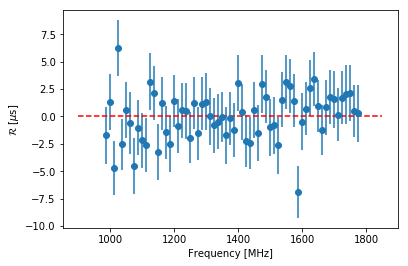

In [47]:
par_file = "B1855+09_NANOGrav_11yv0_Example.par"
tim_files = ["thinkpad_myfirstMJD_B1855+09_AllFreqs_FULL.tim"]

ALL_FIT_JUMPS = []
ALL_FIT_JUMP_ERRS = []

ALL_INPUT_FDS = []
ALL_INPUT_FD_ERRS = []
ALL_FIT_FDS = []
ALL_FIT_FD_ERRS = []

ALL_INPUT_DMS = []
ALL_FIT_DMS = []
ALL_FIT_DM_ERRS = []
for tim_file in tim_files:
    # read in the toas
    t = toa.get_TOAs(tim_file, ephem='DE436', usepickle=False) # Currently AO is telescope used
                
    
    # Change the earth velocity to 0
    t.table.remove_column('ssb_obs_vel')
    t.table.columns['ssb_obs_vel'] = table.Column(name='ssb_obs_vel',\
                                        data=np.zeros((t.ntoas, 3), dtype=np.float64),\
                                        unit=u.km/u.s, meta={'origin':'SSB', 'obj':'OBS'})
    
    # List for the fit DMs
    fit_FDs = []
    fit_FD_errs = []
    # Want to loop through the sets of TOAs to get 
    # Load in the par file to get the timing model
    m = models.get_model(par_file)
    # print the initial tim file
    print(m.as_parfile())

    FD1_init =  m.FD1.value
    FD2_init =  m.FD2.value
    FD3_init =  m.FD3.value
    FD1_initerr =  m.FD1.uncertainty.value
    FD2_initerr =  m.FD2.uncertainty.value
    FD3_initerr =  m.FD3.uncertainty.value
    FDinitvals = [FD1_init, FD2_init, FD3_init]
    ALL_INPUT_FDS.append(FDinitvals)
    FDiniterrs = [FD1_initerr, FD2_initerr, FD3_initerr]
    ALL_INPUT_FD_ERRS.append(FDiniterrs)

    # Now get the residuals
    rs = r.resids(t, m).time_resids
    rs_phase = r.resids(t, m).phase_resids
    
    # Define our fitter and do the fitting
    f = fit.GLSFitter(t, m)
    
    # Set fit parameters to be empty, e.g. do not fit any parameters.
    # If fitting for DM, FD1,2,3, and JUMP is disired, comment out this line.
    f.set_fitparams()
    
    print(f.get_fitparams())
    
    f.fit_toas()

    # Now we print some information about the residuals that we have
    print("Best fit has reduced chi^2 of", f.resids.chi2_reduced.value)
    print("RMS in time is", f.resids.time_resids.std().to(u.us).value, "us")
    # We also want to grab the fit FD parameters and compare them to the original values
    FD1_fit = f.model.FD1.value
    FD1_fit_err = f.model.FD1.uncertainty_value
    FD2_fit = f.model.FD2.value
    FD2_fit_err = f.model.FD2.uncertainty_value
    FD3_fit = f.model.FD3.value
    FD3_fit_err = f.model.FD3.uncertainty_value
    # Go back to the normal list for recutting
    ALL_FIT_FDS.append([FD1_fit, FD2_fit, FD3_fit])
    ALL_FIT_FD_ERRS.append([FD1_fit_err, FD2_fit_err, FD3_fit_err])
    # Get the jump value
    ALL_FIT_JUMPS.append(f.model.JUMP1.value)
    ALL_FIT_JUMP_ERRS.append(f.model.JUMP1.uncertainty.value)
    print("JUMP value is: %.3f us" % (f.model.JUMP1.value*10**6))
    
    fit_DMs = [f.model.DM.value]
    fit_DM_errs = [f.model.DM.uncertainty_value]
    ALL_FIT_DMS.append(fit_DMs)
    ALL_FIT_DM_ERRS.append(fit_DM_errs)
    
    print(fit_DMs, ALL_FIT_FDS)
    
    plt.errorbar(t.get_freqs().value, f.resids.time_resids.to(u.us).value, \
        t.get_errors().to(u.us).value, fmt='o')
    plt.plot(np.linspace(900.0, 1850.0, 10), np.repeat(0.0, 10), c = 'r', ls = '--')
    plt.xlabel(r'Frequency [MHz]')
    plt.ylabel(r'${\cal{R}}$ [$\mu$s]')
    plt.show()
    plt.close()
